### 네이버 영화 평점 크롤링

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

url = 'https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cur&date=20200402'
page = urlopen(url)

soup = BeautifulSoup(page, 'html.parser')
soup


<!DOCTYPE html>

<html lang="ko">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="http://imgmovie.naver.com/today/naverme/naverme_profile.jpg" property="me2:image">
<meta content="네이버영화 " property="me2:post_tag">
<meta content="네이버영화" property="me2:category1"/>
<meta content="" property="me2:category2"/>
<meta content="랭킹 : 네이버 영화" property="og:title"/>
<meta content="영화, 영화인, 예매, 박스오피스 랭킹 정보 제공" property="og:description"/>
<meta content="article" property="og:type"/>
<meta content="https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cur&amp;date=20200402" property="og:url"/>
<meta content="http://static.naver.net/m/movie/icons/OG_270_270.png" property="og:image"/><!-- http://static.naver.net/m/movie/im/navermovie.jpg -->
<meta content="http://imgmovie.naver.com/today/naverme/naverme_profile.jpg" property="og:article:thumbnailUrl"/>
<meta content="네이버 영화" property="og:article:author"/>


In [2]:
soup.find_all('div', 'tit5')

[<div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=19099" title="트루먼 쇼">트루먼 쇼</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=148338" title="동급생">동급생</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=187308" title="조조 래빗">조조 래빗</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=168050" title="스타 이즈 본">스타 이즈 본</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=92075" title="어바웃 타임">어바웃 타임</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=173692" title="바울">바울</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=17796" title="일 포스티노">일 포스티노</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=158578" title="흑집사 : 북 오브 더 아틀란틱">흑집사 : 북 오브 더 아틀란틱</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=189000" title="나이브스 아웃">나이브스 아웃</a>
 </div>,
 <div class="tit5">
 <a href="/movie/bi/mi/basic.nhn?code=31801" title="봄날은 간다">봄날은 간다

In [3]:
soup.find_all('div', 'tit5')[0].a

<a href="/movie/bi/mi/basic.nhn?code=19099" title="트루먼 쇼">트루먼 쇼</a>

In [4]:
soup.find_all('div', 'tit5')[0].a.string

'트루먼 쇼'

In [5]:
movie_name = [each.a.string for each in soup.find_all('div', 'tit5')]
movie_name

['트루먼 쇼',
 '동급생',
 '조조 래빗',
 '스타 이즈 본',
 '어바웃 타임',
 '바울',
 '일 포스티노',
 '흑집사 : 북 오브 더 아틀란틱',
 '나이브스 아웃',
 '봄날은 간다',
 '히트',
 '극장판 쿠로코의 농구 라스트 게임',
 '노팅 힐',
 '샤인',
 '타오르는 여인의 초상',
 '비긴 어게인',
 '동감',
 '델마와 루이스',
 '윤희에게',
 '1917',
 '비트',
 '시티 오브 갓',
 '작은 아씨들',
 '천로역정: 천국을 찾아서',
 '너의 이름은.',
 '우리집',
 '가장 따뜻한 색, 블루',
 '벌새',
 '부르고뉴, 와인에서 찾은 인생',
 '부당거래',
 '브리짓 존스의 일기',
 '그을린 사랑',
 '다크 워터스',
 '라라랜드',
 '내일을 위한 시간',
 '울프 콜',
 '미드나잇 인 파리',
 '더 와이프',
 '러브 라이브! 더 스쿨 아이돌 무비',
 '기생충',
 '스틸 앨리스',
 '아무르',
 '500일의 썸머',
 '레토',
 '그랜드 부다페스트 호텔',
 '러브 라이브! 선샤인!! 더 스쿨 아이돌 무비 오버 더 레인보우',
 '케빈에 대하여',
 '유스',
 '젠틀맨',
 '우리도 사랑일까']

In [6]:
soup.find_all('td', 'point')[0].string

'9.33'

In [7]:
movie_point = [each.string for each in soup.find_all('td', 'point')]
movie_point

['9.33',
 '9.20',
 '9.18',
 '9.17',
 '9.16',
 '9.16',
 '9.15',
 '9.15',
 '9.11',
 '9.10',
 '9.09',
 '9.09',
 '9.08',
 '9.08',
 '9.05',
 '9.02',
 '8.98',
 '8.96',
 '8.94',
 '8.93',
 '8.85',
 '8.83',
 '8.82',
 '8.77',
 '8.77',
 '8.76',
 '8.76',
 '8.76',
 '8.69',
 '8.69',
 '8.67',
 '8.65',
 '8.61',
 '8.60',
 '8.55',
 '8.54',
 '8.53',
 '8.51',
 '8.51',
 '8.49',
 '8.47',
 '8.45',
 '8.41',
 '8.41',
 '8.38',
 '8.37',
 '8.36',
 '8.30',
 '8.28',
 '8.28']

In [8]:
date = pd.date_range('2020.02.16', periods=45, freq='D')
date

DatetimeIndex(['2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19',
               '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
               '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
               '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
               '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14',
               '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
               '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
               '2020-03-31'],
              dtype='datetime64[ns]', freq='D')

In [9]:
date[0]

Timestamp('2020-02-16 00:00:00', freq='D')

In [10]:
date[0].strftime('%y-%m-%d')

'20-02-16'

In [11]:
date[0].strftime('%y.%m.%d')

'20.02.16'

In [12]:
date[0].strftime('%y%m%d')

'200216'

In [13]:
date[0].strftime('%Y%m%d')

'20200216'

In [14]:
movie_date = []
movie_name = []
movie_point = []

In [15]:
for today in date:
    html = 'https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cur&date={date}'
    response = urlopen(html.format(date=today.strftime('%Y%m%d')))
    soup = BeautifulSoup(response, 'html.parser')
    
    movie_date.extend([today]*len(soup.find_all('td', 'point')))
    movie_name.extend([each.a.string for each in soup.find_all('div', 'tit5')])        
    movie_point.extend([each.string for each in soup.find_all('td', 'point')])    

    print(str(today))
    time.sleep(0.5)

2020-02-16 00:00:00
2020-02-17 00:00:00
2020-02-18 00:00:00
2020-02-19 00:00:00
2020-02-20 00:00:00
2020-02-21 00:00:00
2020-02-22 00:00:00
2020-02-23 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-26 00:00:00
2020-02-27 00:00:00
2020-02-28 00:00:00
2020-02-29 00:00:00
2020-03-01 00:00:00
2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:00:00
2020-03-05 00:00:00
2020-03-06 00:00:00
2020-03-07 00:00:00
2020-03-08 00:00:00
2020-03-09 00:00:00
2020-03-10 00:00:00
2020-03-11 00:00:00
2020-03-12 00:00:00
2020-03-13 00:00:00
2020-03-14 00:00:00
2020-03-15 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-21 00:00:00
2020-03-22 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-28 00:00:00
2020-03-29 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00


In [16]:
len(movie_date), len(movie_name),  len(movie_point)

(2130, 2130, 2130)

In [17]:
movie = pd.DataFrame({'date': movie_date, 'name': movie_name, 'point': movie_point})
movie.head()

,date,name,point
0,2020-02-16,그린 북,9.61
1,2020-02-16,포드 V 페라리,9.51
2,2020-02-16,두 교황,9.35
3,2020-02-16,조조 래빗,9.35
4,2020-02-16,울지마 톤즈,9.34


In [18]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2130 non-null   datetime64[ns]
 1   name    2130 non-null   object        
 2   point   2130 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 50.0+ KB


In [19]:
movie['point'] = movie['point'].astype(float)
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2130 non-null   datetime64[ns]
 1   name    2130 non-null   object        
 2   point   2130 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 50.0+ KB


In [20]:
movie.to_csv('./naver_movie_raw_data.csv', sep=',', encoding='utf-8')

In [21]:
movie = pd.read_csv('./naver_movie_raw_data.csv', index_col=0)
movie.head()

,date,name,point
0,2020-02-16,그린 북,9.61
1,2020-02-16,포드 V 페라리,9.51
2,2020-02-16,두 교황,9.35
3,2020-02-16,조조 래빗,9.35
4,2020-02-16,울지마 톤즈,9.34


영화 이름으로 인덱스를 잡고 점수의 합산

In [22]:
movie_unique = pd.pivot_table(movie, index=['name'], aggfunc=np.sum)
movie_unique.head()

,point
name,
1917,376.93
21 브릿지: 테러 셧다운,47.60
500일의 썸머,117.74
82년생 김지영,66.90
걸어도 걸어도,129.15


한달 간 네이터 영화 평점 합산 기준 베스트 10

In [23]:
movie_best = movie_unique.sort_values(by='point', ascending=False)
movie_best.tail(10)

,point
name,
바르다가 사랑한 얼굴들,8.88
시티 오브 갓,8.83
브리짓 존스의 베이비,8.80
너의 이름은.,8.76
그을린 사랑,8.65
환상의 빛,7.97
싸움의 기술,7.92
종이 달,7.91
철벽선생,7.65


DataFrame의 검색 명령 : query

In [24]:
movie.query('name == ["작은 아씨들"]')

,date,name,point
16,2020-02-16,작은 아씨들,8.95
57,2020-02-17,작은 아씨들,8.95
100,2020-02-18,작은 아씨들,8.94
144,2020-02-19,작은 아씨들,8.93
188,2020-02-20,작은 아씨들,8.93
233,2020-02-21,작은 아씨들,8.91
278,2020-02-22,작은 아씨들,8.90
320,2020-02-23,작은 아씨들,8.89
364,2020-02-24,작은 아씨들,8.89
407,2020-02-25,작은 아씨들,8.88


한 영화에 대한 날짜별 점수

No handles with labels found to put in legend.


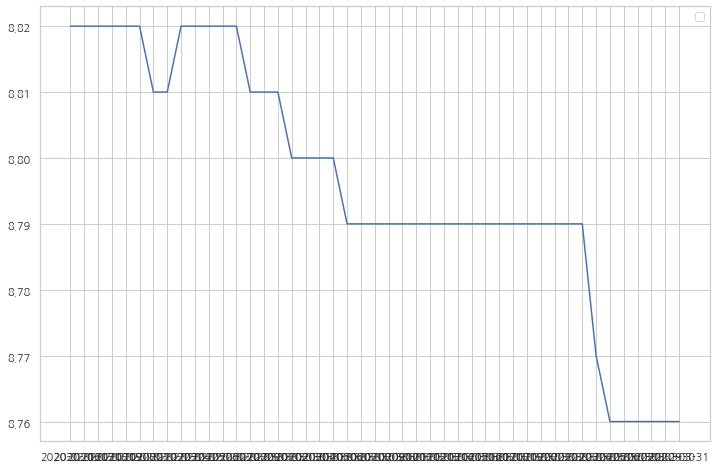

In [25]:
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.plot(movie.query('name == ["벌새"]')['date'],
        movie.query('name == ["벌새"]')['point'])
plt.legend(loc='best')
plt.grid()
plt.grid(); plt.show()

In [26]:
movie_best.head(10)

,point
name,
포드 V 페라리,418.23
조조 래빗,414.40
나이브스 아웃,410.06
결혼 이야기,408.32
타오르는 여인의 초상,406.82
두 교황,400.56
작은 아씨들,399.15
벌새,395.82
아이리시맨,387.03


In [27]:
movie_best.tail(10)

,point
name,
바르다가 사랑한 얼굴들,8.88
시티 오브 갓,8.83
브리짓 존스의 베이비,8.80
너의 이름은.,8.76
그을린 사랑,8.65
환상의 빛,7.97
싸움의 기술,7.92
종이 달,7.91
철벽선생,7.65


한 달 간의 영화를 모두 정리

In [28]:
movie_pivot = pd.pivot_table(movie, index=['date'], columns=['name'])
movie_pivot.columns = movie_pivot.columns.droplevel([0])
movie_pivot.head()

name,1917,21 브릿지: 테러 셧다운,500일의 썸머,82년생 김지영,걸어도 걸어도,겟 아웃,겨울왕국 2,결혼 이야기,공기인형,교회오빠,...,파이트 클럽,포드 V 페라리,포레스트 검프,피아니스트의 전설,해리 포터와 아즈카반의 죄수,해치지않아,환상의 빛,흑집사 : 북 오브 더 아틀란틱,히트,히트맨
date,,,,,,,,,,,,,,,,,,,,,
2020-02-16,NaN,7.95,NaN,6.69,NaN,NaN,8.71,9.07,7.09,NaN,...,NaN,9.51,NaN,9.26,NaN,6.17,NaN,NaN,NaN,7.15
2020-02-17,NaN,7.93,NaN,6.69,NaN,NaN,8.71,9.08,7.09,NaN,...,NaN,9.51,NaN,9.25,NaN,6.16,NaN,NaN,NaN,7.15
2020-02-18,NaN,7.93,NaN,6.69,NaN,NaN,8.70,9.08,7.09,NaN,...,NaN,9.51,NaN,9.25,NaN,6.16,NaN,NaN,NaN,7.14
2020-02-19,9.16,7.93,NaN,6.69,NaN,NaN,8.70,9.08,7.09,NaN,...,NaN,9.51,NaN,9.25,NaN,6.15,NaN,NaN,NaN,7.14
2020-02-20,9.12,7.93,NaN,6.69,NaN,NaN,8.70,9.08,7.09,NaN,...,NaN,9.51,NaN,9.25,NaN,NaN,NaN,NaN,NaN,7.14


엑셀로 저장

In [29]:
movie_pivot.to_excel('./movie_pivot.xlsx')

In [30]:
movie_pivot.columns

Index(['1917', '21 브릿지: 테러 셧다운', '500일의 썸머', '82년생 김지영', '걸어도 걸어도', '겟 아웃',
       '겨울왕국 2', '결혼 이야기', '공기인형', '교회오빠',
       ...
       '파이트 클럽', '포드 V 페라리', '포레스트 검프', '피아니스트의 전설', '해리 포터와 아즈카반의 죄수',
       '해치지않아', '환상의 빛', '흑집사 : 북 오브 더 아틀란틱', '히트', '히트맨'],
      dtype='object', name='name', length=136)

보고싶은 영화 몇개만 추려서 그래프로 확인

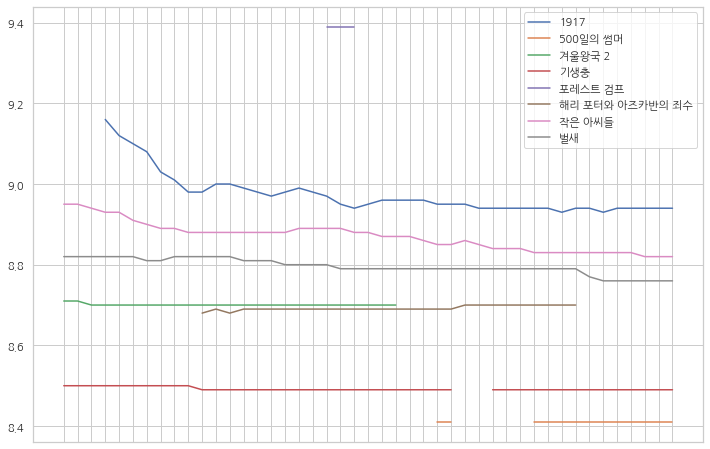

In [31]:
target_col = ['1917', '500일의 썸머', '겨울왕국 2', '기생충', '포레스트 검프', '해리 포터와 아즈카반의 죄수', '작은 아씨들', '벌새']

plt.figure(figsize=(12, 8))
plt.plot(movie_pivot[target_col])
plt.legend(target_col, loc='best')
plt.tick_params(bottom=False, labelbottom=False)
plt.show()